In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import numpy as np

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


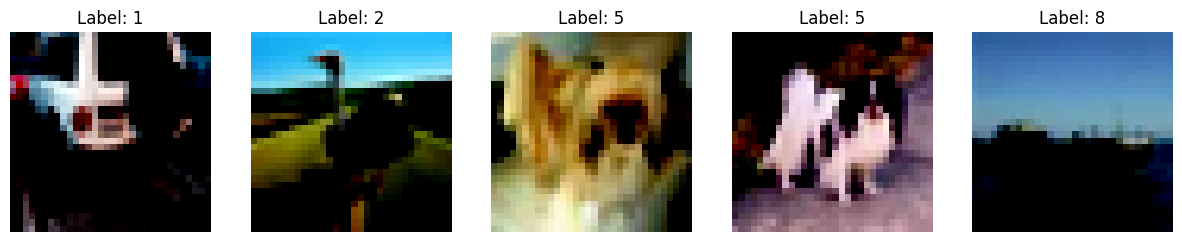

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


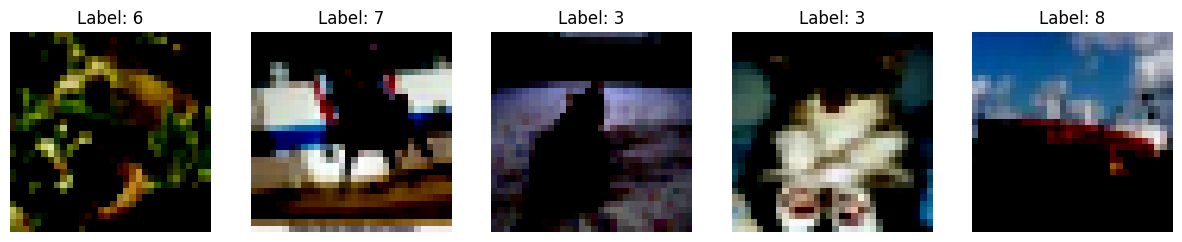

In [4]:
import random

# Function to display random images with labels from the dataset
def display_random_images_with_labels(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset[index]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

# Display random images with labels from the training dataset
display_random_images_with_labels(train_dataset)

# Display random images with labels from the test dataset
display_random_images_with_labels(test_dataset)

In [5]:
# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [6]:
# Display sizes of train, test, and validation sets
print(f"Size of the training set: {len(train_dataset)}")
print(f"Size of the validation set: {len(val_dataset)}")
print(f"Size of the test set: {len(test_dataset)}")

Size of the training set: 40000
Size of the validation set: 10000
Size of the test set: 10000


In [7]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs=100):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        start_time = time.time()  # Record start time for the epoch

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            predicted_probs = torch.softmax(outputs, 1)
            _, predicted = torch.max(predicted_probs, 1)  # Get the predicted class labels
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                predicted_probs = torch.softmax(outputs, 1)
                _, predicted = torch.max(predicted_probs, 1)  # Get the predicted class labels
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val

        end_time = time.time()  # Record end time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch time

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Time: {epoch_time:.2f} seconds")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs

In [8]:
# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [9]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
            outputs = model(inputs)
            predicted = torch.argmax(torch.softmax(outputs, 1), dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    return test_accuracy


### Variant 1: 

#### A) SELU Activation Function

In [10]:
# Variant 1: SELU Activation
class MiniVGG_v1_a(nn.Module):
    def __init__(self):
        super(MiniVGG_v1_a, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.selu(self.conv1(x))
        x = torch.selu(self.conv2(x))
        x = self.maxpool1(x)
        x = torch.selu(self.conv3(x))
        x = torch.selu(self.conv4(x))
        x = self.maxpool2(x)
        x = torch.selu(self.conv5(x))
        x = torch.selu(self.conv6(x))
        x = self.maxpool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = torch.selu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
from tabulate import tabulate

# Define table headers and data
headers = ["Layer Type", "Window Size", "Number of Filters"]
data = [
    ["Convolutional", "(3x3)", "64"],
    ["Convolutional", "(3x3)", "64"],
    ["MaxPool", "(2x2)", "-"],
    ["Convolutional", "(3x3)", "128"],
    ["Convolutional", "(3x3)", "128"],
    ["MaxPool", "(2x2)", "-"],
    ["Convolutional", "(3x3)", "256"],
    ["Convolutional", "(3x3)", "256"],
    ["MaxPool", "(2x2)", "-"],
    ["Fully Connected", "-", "512"],
    ["Fully Connected", "-", "10"]
]

# Display table for Variant 1
print(tabulate(data, headers=headers, tablefmt="grid"))

+-----------------+---------------+---------------------+
| Layer Type      | Window Size   | Number of Filters   |
+=================+===============+=====================+
| Convolutional   | (3x3)         | 64                  |
+-----------------+---------------+---------------------+
| Convolutional   | (3x3)         | 64                  |
+-----------------+---------------+---------------------+
| MaxPool         | (2x2)         | -                   |
+-----------------+---------------+---------------------+
| Convolutional   | (3x3)         | 128                 |
+-----------------+---------------+---------------------+
| Convolutional   | (3x3)         | 128                 |
+-----------------+---------------+---------------------+
| MaxPool         | (2x2)         | -                   |
+-----------------+---------------+---------------------+
| Convolutional   | (3x3)         | 256                 |
+-----------------+---------------+---------------------+
| Convolutiona

In [12]:
# Initialize MiniVGG_v1_a model and move it to GPU if available
model_v1_a = MiniVGG_v1_a().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v1_a.parameters(), lr=0.001)

# Train MiniVGG_v1_a model
train_losses_v1_a, val_losses_v1_a, train_accs_v1_a, val_accs_v1_a = train(model_v1_a, criterion, optimizer, train_loader, val_loader, num_epochs=70)

Epoch 1/70, Train Loss: 1.4274, Val Loss: 1.1390, Train Acc: 0.5003, Val Acc: 0.6118, Time: 3.66 seconds
Epoch 2/70, Train Loss: 1.0309, Val Loss: 0.9464, Train Acc: 0.6434, Val Acc: 0.6707, Time: 3.55 seconds
Epoch 3/70, Train Loss: 0.8658, Val Loss: 0.9793, Train Acc: 0.7032, Val Acc: 0.6553, Time: 3.39 seconds
Epoch 4/70, Train Loss: 0.7530, Val Loss: 0.9735, Train Acc: 0.7492, Val Acc: 0.6876, Time: 3.59 seconds
Epoch 5/70, Train Loss: 0.6606, Val Loss: 0.9731, Train Acc: 0.7791, Val Acc: 0.7081, Time: 3.45 seconds
Epoch 6/70, Train Loss: 0.5814, Val Loss: 1.0379, Train Acc: 0.8076, Val Acc: 0.6934, Time: 3.39 seconds
Epoch 7/70, Train Loss: 0.5248, Val Loss: 1.0308, Train Acc: 0.8300, Val Acc: 0.7278, Time: 3.60 seconds
Epoch 8/70, Train Loss: 0.4663, Val Loss: 1.0876, Train Acc: 0.8535, Val Acc: 0.7135, Time: 3.50 seconds
Epoch 9/70, Train Loss: 0.4343, Val Loss: 1.0498, Train Acc: 0.8677, Val Acc: 0.7303, Time: 3.53 seconds
Epoch 10/70, Train Loss: 0.4064, Val Loss: 1.2353, Trai

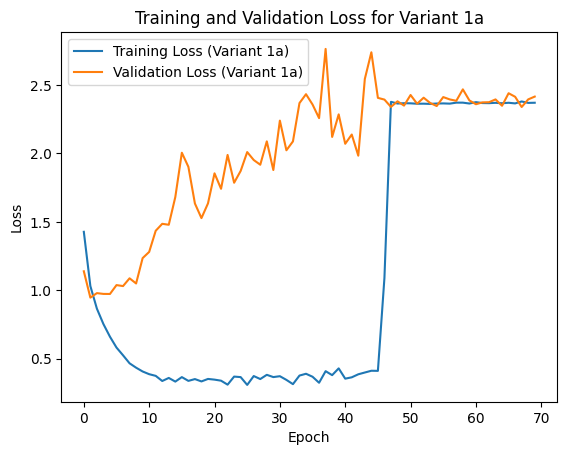

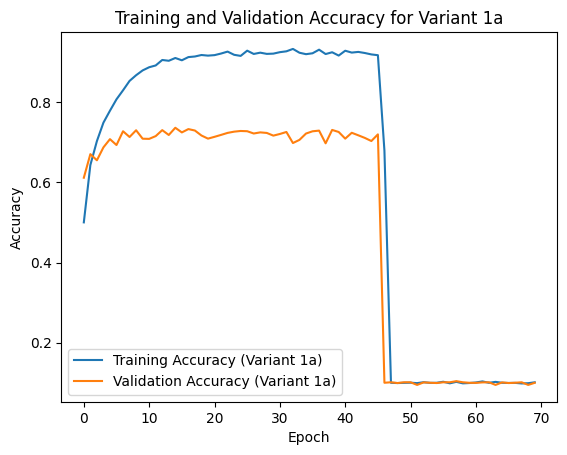

Test Accuracy for MiniVGG model (SELU Activation): 0.1000


In [13]:
# Plot training and validation loss for Variant 1a
plt.plot(train_losses_v1_a, label='Training Loss (Variant 1a)')
plt.plot(val_losses_v1_a, label='Validation Loss (Variant 1a)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Variant 1a')
plt.legend()
plt.show()

# Plot training and validation accuracy for Variant 1a
plt.plot(train_accs_v1_a, label='Training Accuracy (Variant 1a)')
plt.plot(val_accs_v1_a, label='Validation Accuracy (Variant 1a)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Variant 1a')
plt.legend()
plt.show()

# Test the Variant 1a model
test_accuracy_v1_a = test(model_v1_a, test_loader)
print(f"Test Accuracy for MiniVGG model (SELU Activation): {test_accuracy_v1_a:.4f}")

### Data Augmentation

In [14]:
# Define data augmentation and normalization transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets with transformations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_test)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_test)

# Define data loaders
# Move data loaders to GPU
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# Display the number of samples in the training, validation, and testing sets
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of testing samples:", len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 50000
Number of validation samples: 10000
Number of testing samples: 10000


### Batch Normalzation

In [15]:
# Define MiniVGG_BN model
class MiniVGG_BN_SELU(nn.Module):
    def __init__(self):
        super(MiniVGG_BN_SELU, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.bn1(torch.selu(self.conv1(x)))
        x = self.bn2(torch.selu(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.bn3(torch.selu(self.conv3(x)))
        x = self.bn4(torch.selu(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.bn5(torch.selu(self.conv5(x)))
        x = self.bn6(torch.selu(self.conv6(x)))
        x = self.maxpool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.bn_fc1(torch.selu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [16]:
# Initialize MiniVGG_BN model
model_bn = MiniVGG_BN_SELU().to(device)  # Move model to GPU if available

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)

# Train MiniVGG_BN model with early stopping
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_bn, criterion, optimizer_bn, train_loader, val_loader, num_epochs=80)

Epoch 1/80, Train Loss: 1.3577, Val Loss: 0.9343, Train Acc: 0.5166, Val Acc: 0.6748, Time: 8.82 seconds
Epoch 2/80, Train Loss: 0.9357, Val Loss: 0.7351, Train Acc: 0.6679, Val Acc: 0.7411, Time: 8.57 seconds
Epoch 3/80, Train Loss: 0.7774, Val Loss: 0.6278, Train Acc: 0.7288, Val Acc: 0.7904, Time: 8.63 seconds
Epoch 4/80, Train Loss: 0.6834, Val Loss: 0.5653, Train Acc: 0.7614, Val Acc: 0.8047, Time: 8.55 seconds
Epoch 5/80, Train Loss: 0.6003, Val Loss: 0.5383, Train Acc: 0.7920, Val Acc: 0.8187, Time: 8.61 seconds
Epoch 6/80, Train Loss: 0.5424, Val Loss: 0.4785, Train Acc: 0.8118, Val Acc: 0.8421, Time: 8.64 seconds
Epoch 7/80, Train Loss: 0.4985, Val Loss: 0.4892, Train Acc: 0.8269, Val Acc: 0.8330, Time: 8.62 seconds
Epoch 8/80, Train Loss: 0.4545, Val Loss: 0.4347, Train Acc: 0.8408, Val Acc: 0.8491, Time: 8.70 seconds
Epoch 9/80, Train Loss: 0.4299, Val Loss: 0.3969, Train Acc: 0.8493, Val Acc: 0.8655, Time: 8.57 seconds
Epoch 10/80, Train Loss: 0.3926, Val Loss: 0.4077, Trai

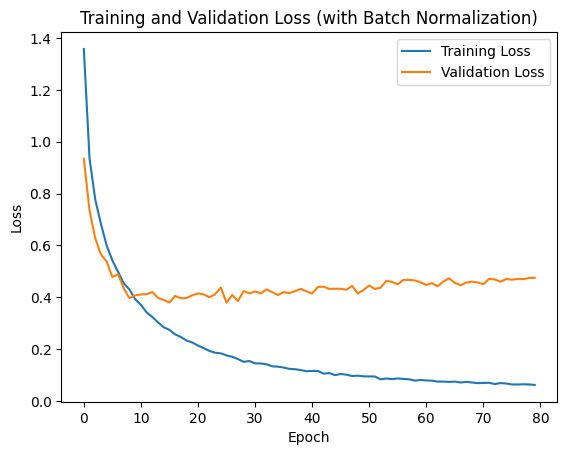

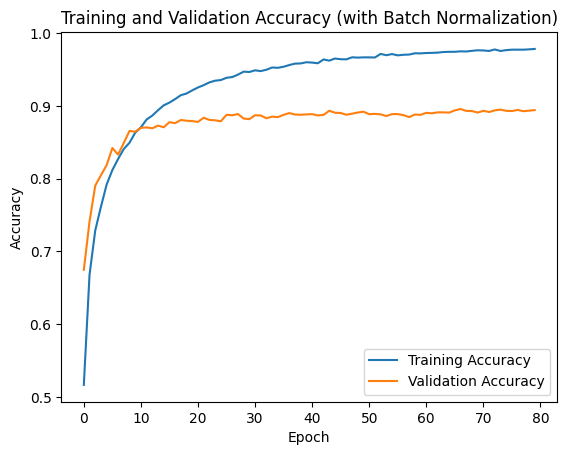

Test Accuracy for MiniVGG_BN_SELU model that uses SELU (with Batch Normalization): 0.8942


In [17]:
# Plotting training and validation loss
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(val_losses_bn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Batch Normalization)')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_accs_bn, label='Training Accuracy')
plt.plot(val_accs_bn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with Batch Normalization)')
plt.legend()
plt.show()

test_accuracy_bn = test(model_bn, test_loader)
print(f"Test Accuracy for MiniVGG_BN_SELU model that uses SELU (with Batch Normalization): {test_accuracy_bn:.4f}")

### L2 Regularization with weight decay of 0.0001

In [18]:
# Initialize MiniVGG_BN model
model_bn = MiniVGG_BN_SELU().to(device)  # Move model to GPU if available

# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001, weight_decay=0.0001)   # Define L2 regularization strength (lambda)

# Train MiniVGG_BN model with early stopping
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_bn, criterion, optimizer_bn, train_loader, val_loader, num_epochs=130)

Epoch 1/130, Train Loss: 1.3759, Val Loss: 1.0067, Train Acc: 0.5067, Val Acc: 0.6516, Time: 8.64 seconds
Epoch 2/130, Train Loss: 0.9503, Val Loss: 0.7589, Train Acc: 0.6654, Val Acc: 0.7366, Time: 8.59 seconds
Epoch 3/130, Train Loss: 0.7959, Val Loss: 0.6329, Train Acc: 0.7205, Val Acc: 0.7830, Time: 8.65 seconds
Epoch 4/130, Train Loss: 0.6964, Val Loss: 0.5871, Train Acc: 0.7575, Val Acc: 0.8026, Time: 8.82 seconds
Epoch 5/130, Train Loss: 0.6231, Val Loss: 0.5233, Train Acc: 0.7842, Val Acc: 0.8214, Time: 8.49 seconds
Epoch 6/130, Train Loss: 0.5803, Val Loss: 0.4774, Train Acc: 0.7975, Val Acc: 0.8357, Time: 8.66 seconds
Epoch 7/130, Train Loss: 0.5374, Val Loss: 0.4849, Train Acc: 0.8134, Val Acc: 0.8334, Time: 8.67 seconds
Epoch 8/130, Train Loss: 0.5030, Val Loss: 0.4563, Train Acc: 0.8260, Val Acc: 0.8416, Time: 8.53 seconds
Epoch 9/130, Train Loss: 0.4829, Val Loss: 0.4341, Train Acc: 0.8320, Val Acc: 0.8531, Time: 8.62 seconds
Epoch 10/130, Train Loss: 0.4592, Val Loss: 0.

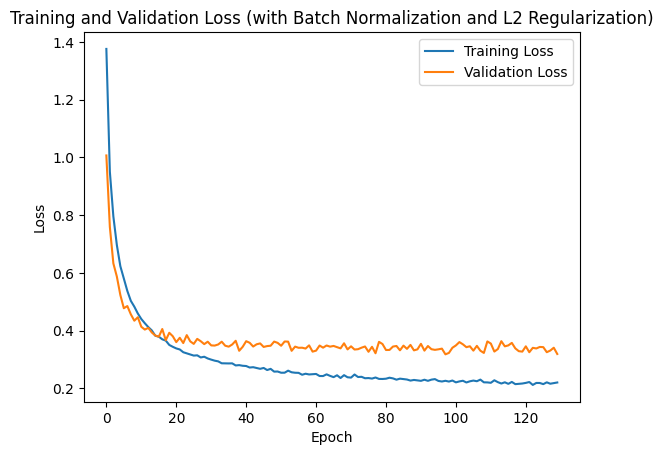

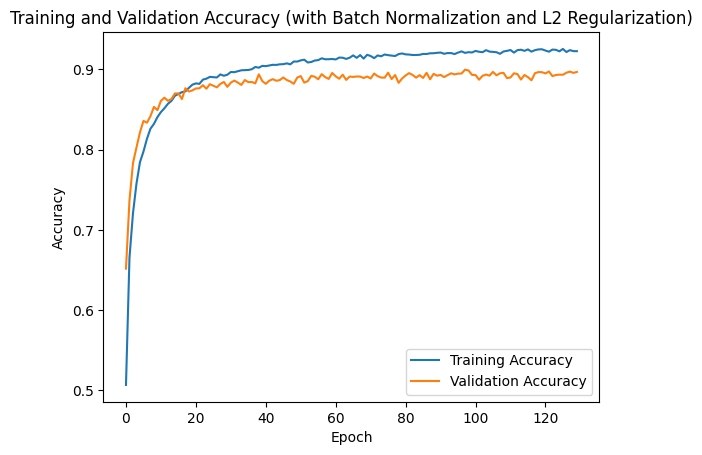

Test Accuracy for MiniVGG_BN_SELU model that uses SELU (with Batch Normalization and L2 Regularization): 0.8967


In [19]:
# Plotting training and validation loss
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(val_losses_bn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_accs_bn, label='Training Accuracy')
plt.plot(val_accs_bn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

test_accuracy_bn = test(model_bn, test_loader)
print(f"Test Accuracy for MiniVGG_BN_SELU model that uses SELU (with Batch Normalization and L2 Regularization): {test_accuracy_bn:.4f}")

____

___

_____

#### B) Swish Activation Function

In [20]:
# Reference to implement swish in torch: https://www.geeksforgeeks.org/swish-activation-function-in-pytorch/
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Variant 2: Swish Activation
class MiniVGG_v1_b(nn.Module):
    def __init__(self):
        super(MiniVGG_v1_b, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.swish = Swish()

    def forward(self, x):
        x = self.swish(self.conv1(x)) 
        x = self.swish(self.conv2(x))
        x = self.maxpool1(x)
        x = self.swish(self.conv3(x))
        x = self.swish(self.conv4(x))
        x = self.maxpool2(x)
        x = self.swish(self.conv5(x))
        x = self.swish(self.conv6(x))
        x = self.maxpool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.swish(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
# Initialize MiniVGG_v1_b model
model_v1_b = MiniVGG_v1_b().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v1_b.parameters(), lr=0.001)

# Train MiniVGG_v1_b model
train_losses_v1_b, val_losses_v1_b, train_accs_v1_b, val_accs_v1_b = train(model_v1_b, criterion, optimizer, train_loader, val_loader,  num_epochs=70)

Epoch 1/70, Train Loss: 1.5873, Val Loss: 1.2188, Train Acc: 0.4256, Val Acc: 0.5693, Time: 9.53 seconds
Epoch 2/70, Train Loss: 1.1269, Val Loss: 0.8839, Train Acc: 0.6044, Val Acc: 0.6921, Time: 9.51 seconds
Epoch 3/70, Train Loss: 0.9312, Val Loss: 0.8007, Train Acc: 0.6742, Val Acc: 0.7278, Time: 9.25 seconds
Epoch 4/70, Train Loss: 0.8202, Val Loss: 0.6987, Train Acc: 0.7153, Val Acc: 0.7570, Time: 9.19 seconds
Epoch 5/70, Train Loss: 0.7435, Val Loss: 0.7058, Train Acc: 0.7422, Val Acc: 0.7609, Time: 9.81 seconds
Epoch 6/70, Train Loss: 0.6859, Val Loss: 0.6122, Train Acc: 0.7618, Val Acc: 0.7944, Time: 9.49 seconds
Epoch 7/70, Train Loss: 0.6353, Val Loss: 0.6062, Train Acc: 0.7814, Val Acc: 0.7968, Time: 9.58 seconds
Epoch 8/70, Train Loss: 0.6085, Val Loss: 0.5960, Train Acc: 0.7898, Val Acc: 0.7985, Time: 9.57 seconds
Epoch 9/70, Train Loss: 0.5712, Val Loss: 0.5744, Train Acc: 0.8032, Val Acc: 0.8098, Time: 9.39 seconds
Epoch 10/70, Train Loss: 0.5471, Val Loss: 0.5980, Trai

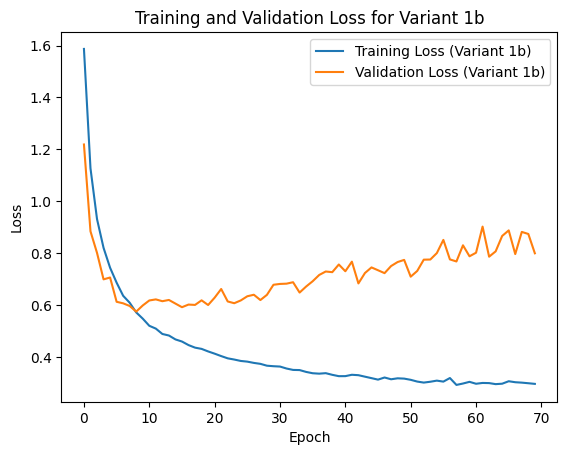

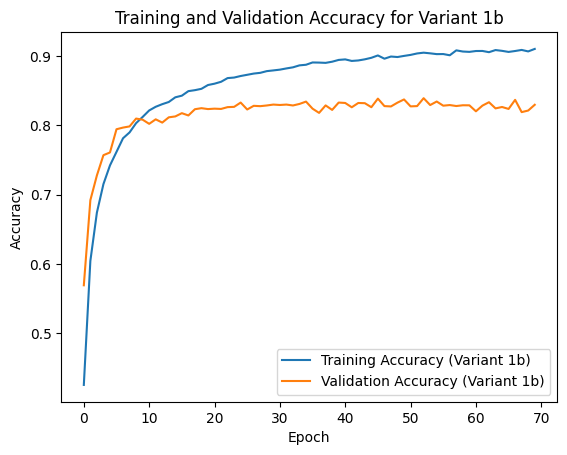

Test Accuracy for MiniVGG model (Swish Activation): 0.8297


In [22]:
# Plot training and validation loss for Variant 1b
plt.plot(train_losses_v1_b, label='Training Loss (Variant 1b)')
plt.plot(val_losses_v1_b, label='Validation Loss (Variant 1b)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Variant 1b')
plt.legend()
plt.show()

# Plot training and validation accuracy for Variant 1b
plt.plot(train_accs_v1_b, label='Training Accuracy (Variant 1b)')
plt.plot(val_accs_v1_b, label='Validation Accuracy (Variant 1b)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Variant 1b')
plt.legend()
plt.show()

# Test the Variant 1b model
test_accuracy_v1_b = test(model_v1_b, test_loader)
print(f"Test Accuracy for MiniVGG model (Swish Activation): {test_accuracy_v1_b:.4f}")

### Batch Normalization

In [23]:
# Define MiniVGG_BN_Swish model
class MiniVGG_BN_Swish(nn.Module):
    def __init__(self):
        super(MiniVGG_BN_Swish, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        self.swish = Swish()

    def forward(self, x):
        x = self.swish(self.bn1(self.conv1(x))) 
        x = self.swish(self.bn2(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.swish(self.bn3(self.conv3(x)))
        x = self.swish(self.bn4(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.swish(self.bn5(self.conv5(x)))
        x = self.swish(self.bn6(self.conv6(x)))
        x = self.maxpool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.swish(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x

In [24]:
# Initialize MiniVGG_BN_Swish model
model_bn = MiniVGG_BN_Swish().to(device)  # Create an instance of the model and move it to GPU if available

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)

# Train MiniVGG_BN_Swish model
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_bn, criterion, optimizer_bn, train_loader, val_loader, num_epochs=80)

Epoch 1/80, Train Loss: 1.2606, Val Loss: 0.9046, Train Acc: 0.5485, Val Acc: 0.6888, Time: 8.97 seconds
Epoch 2/80, Train Loss: 0.8698, Val Loss: 0.7024, Train Acc: 0.6927, Val Acc: 0.7502, Time: 8.89 seconds
Epoch 3/80, Train Loss: 0.7350, Val Loss: 0.5784, Train Acc: 0.7423, Val Acc: 0.7974, Time: 8.69 seconds
Epoch 4/80, Train Loss: 0.6497, Val Loss: 0.5623, Train Acc: 0.7712, Val Acc: 0.8078, Time: 9.48 seconds
Epoch 5/80, Train Loss: 0.5775, Val Loss: 0.4919, Train Acc: 0.7988, Val Acc: 0.8318, Time: 9.41 seconds
Epoch 6/80, Train Loss: 0.5317, Val Loss: 0.4576, Train Acc: 0.8132, Val Acc: 0.8398, Time: 9.62 seconds
Epoch 7/80, Train Loss: 0.4883, Val Loss: 0.4551, Train Acc: 0.8291, Val Acc: 0.8455, Time: 8.93 seconds
Epoch 8/80, Train Loss: 0.4542, Val Loss: 0.4128, Train Acc: 0.8406, Val Acc: 0.8615, Time: 9.40 seconds
Epoch 9/80, Train Loss: 0.4182, Val Loss: 0.3952, Train Acc: 0.8534, Val Acc: 0.8659, Time: 9.77 seconds
Epoch 10/80, Train Loss: 0.3943, Val Loss: 0.4099, Trai

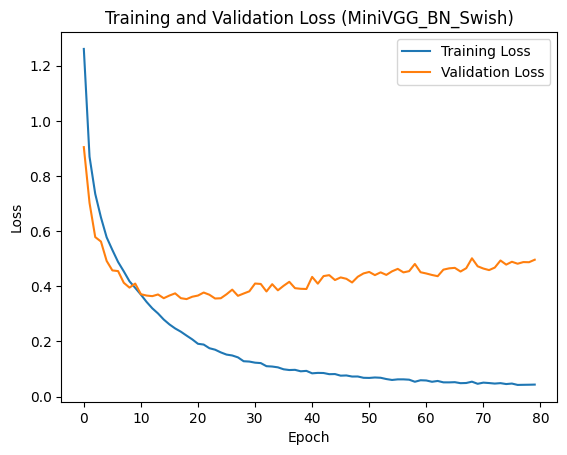

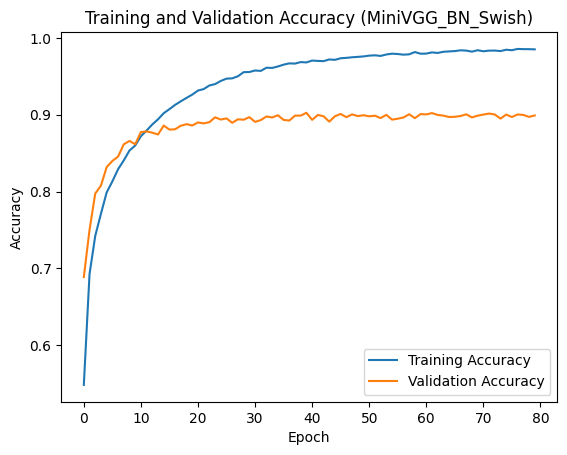

Test Accuracy for MiniVGG_BN_Swish model that uses Swish (with Batch Normalization): 0.8990


In [25]:
#Plotting training and validation loss
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(val_losses_bn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (MiniVGG_BN_Swish)')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_accs_bn, label='Training Accuracy')
plt.plot(val_accs_bn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (MiniVGG_BN_Swish)')
plt.legend()
plt.show()

# Test MiniVGG_BN_Swish model
test_accuracy_bn_swish = test(model_bn, test_loader)
print(f"Test Accuracy for MiniVGG_BN_Swish model that uses Swish (with Batch Normalization): {test_accuracy_bn_swish:.4f}")

### L2 Regularization with weight decay of 0.0001

In [26]:
# Initialize MiniVGG_BN model
model_bn = MiniVGG_BN_Swish().to(device)  # Move model to GPU if available

# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001, weight_decay=0.0001)   # Define L2 regularization strength (lambda)

# Train MiniVGG_BN model with early stopping
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_bn, criterion, optimizer_bn, train_loader, val_loader)

Epoch 1/100, Train Loss: 1.2649, Val Loss: 0.8838, Train Acc: 0.5445, Val Acc: 0.6864, Time: 7.94 seconds
Epoch 2/100, Train Loss: 0.8782, Val Loss: 0.7160, Train Acc: 0.6888, Val Acc: 0.7478, Time: 7.95 seconds
Epoch 3/100, Train Loss: 0.7523, Val Loss: 0.6384, Train Acc: 0.7382, Val Acc: 0.7837, Time: 7.87 seconds
Epoch 4/100, Train Loss: 0.6810, Val Loss: 0.6077, Train Acc: 0.7615, Val Acc: 0.7938, Time: 7.93 seconds
Epoch 5/100, Train Loss: 0.6332, Val Loss: 0.5506, Train Acc: 0.7798, Val Acc: 0.8127, Time: 7.88 seconds
Epoch 6/100, Train Loss: 0.5956, Val Loss: 0.5048, Train Acc: 0.7930, Val Acc: 0.8262, Time: 7.81 seconds
Epoch 7/100, Train Loss: 0.5639, Val Loss: 0.5021, Train Acc: 0.8066, Val Acc: 0.8282, Time: 7.87 seconds
Epoch 8/100, Train Loss: 0.5340, Val Loss: 0.4436, Train Acc: 0.8126, Val Acc: 0.8475, Time: 7.91 seconds
Epoch 9/100, Train Loss: 0.5108, Val Loss: 0.4183, Train Acc: 0.8233, Val Acc: 0.8558, Time: 8.12 seconds
Epoch 10/100, Train Loss: 0.4864, Val Loss: 0.

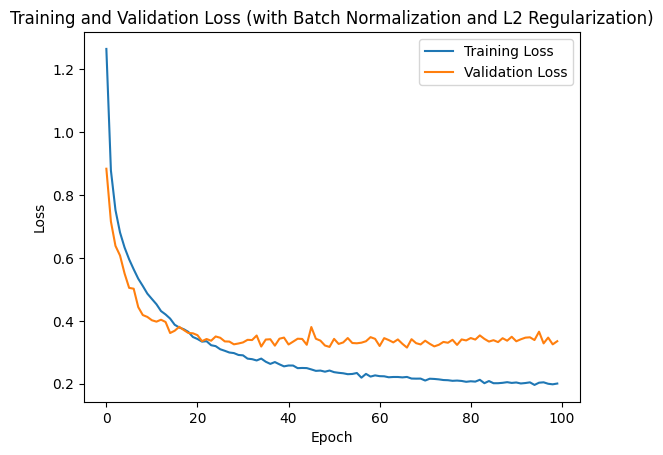

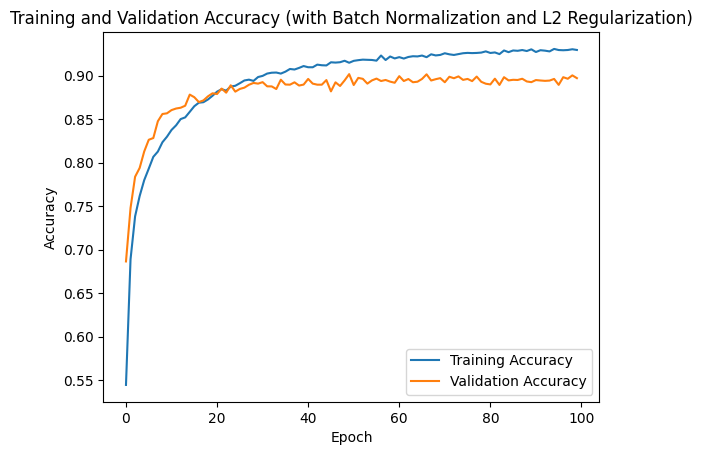

Test Accuracy for MiniVGG_BN_Swish model that uses Swish (with Batch Normalization and L2 Regularization): 0.8970


In [27]:
# Plotting training and validation loss
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(val_losses_bn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_accs_bn, label='Training Accuracy')
plt.plot(val_accs_bn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

test_accuracy_bn = test(model_bn, test_loader)
print(f"Test Accuracy for MiniVGG_BN_Swish model that uses Swish (with Batch Normalization and L2 Regularization): {test_accuracy_bn:.4f}")

### Adding Dropout with probability of 0.1

In [28]:
class MiniVGG_BN_Swish_dropout(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(MiniVGG_BN_Swish_dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(512, 10)
        self.swish = Swish()

    def forward(self, x):
        x = self.swish(self.bn1(self.conv1(x))) 
        x = self.swish(self.bn2(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.swish(self.bn3(self.conv3(x)))
        x = self.swish(self.bn4(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.swish(self.bn5(self.conv5(x)))
        x = self.swish(self.bn6(self.conv6(x)))
        x = self.maxpool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.swish(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)  # Apply dropout to the output of fc1
        x = self.fc2(x)
        return x


In [29]:
model_bn_dropout = MiniVGG_BN_Swish_dropout(dropout_rate=0.1).to(device)  # Move model to GPU if available

# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer_bn_dropout = optim.Adam(model_bn_dropout.parameters(), lr=0.001, weight_decay=0.0001)   # Define L2 regularization strength (lambda)

# Train MiniVGG_BN_Swish_dropout model with early stopping
train_losses_bn_dropout, val_losses_bn_dropout, train_accs_bn_dropout, val_accs_bn_dropout = train(model_bn_dropout, criterion, optimizer_bn_dropout, train_loader, val_loader, num_epochs = 130)

Epoch 1/130, Train Loss: 1.2766, Val Loss: 0.9591, Train Acc: 0.5419, Val Acc: 0.6712, Time: 9.51 seconds
Epoch 2/130, Train Loss: 0.8943, Val Loss: 0.6884, Train Acc: 0.6862, Val Acc: 0.7618, Time: 9.34 seconds
Epoch 3/130, Train Loss: 0.7667, Val Loss: 0.6201, Train Acc: 0.7305, Val Acc: 0.7823, Time: 9.84 seconds
Epoch 4/130, Train Loss: 0.6980, Val Loss: 0.5757, Train Acc: 0.7560, Val Acc: 0.8012, Time: 9.17 seconds
Epoch 5/130, Train Loss: 0.6451, Val Loss: 0.5229, Train Acc: 0.7756, Val Acc: 0.8155, Time: 9.34 seconds
Epoch 6/130, Train Loss: 0.6062, Val Loss: 0.5387, Train Acc: 0.7901, Val Acc: 0.8177, Time: 9.57 seconds
Epoch 7/130, Train Loss: 0.5751, Val Loss: 0.5132, Train Acc: 0.7997, Val Acc: 0.8211, Time: 9.38 seconds
Epoch 8/130, Train Loss: 0.5426, Val Loss: 0.4476, Train Acc: 0.8125, Val Acc: 0.8451, Time: 9.58 seconds
Epoch 9/130, Train Loss: 0.5180, Val Loss: 0.4334, Train Acc: 0.8211, Val Acc: 0.8462, Time: 9.16 seconds
Epoch 10/130, Train Loss: 0.4971, Val Loss: 0.

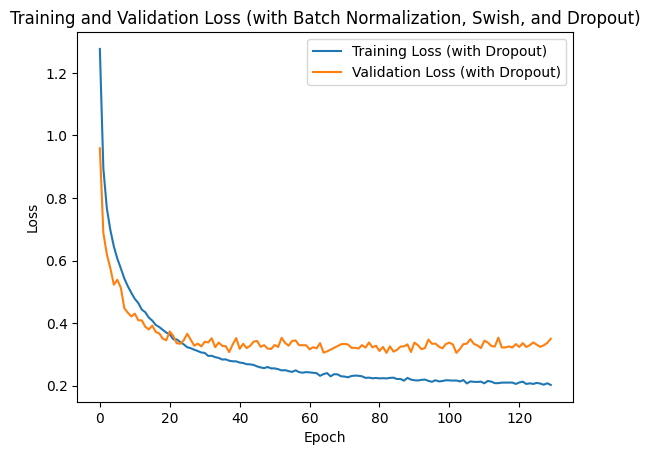

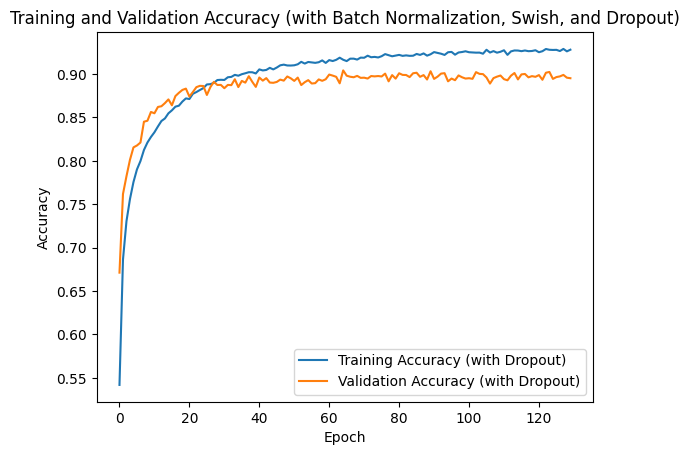

Test Accuracy for MiniVGG_BN_Swish_dropout model (with Batch Normalization, Swish, and Dropout): 0.8952


In [30]:
# Plotting training and validation loss for model with dropout
plt.plot(train_losses_bn_dropout, label='Training Loss (with Dropout)')
plt.plot(val_losses_bn_dropout, label='Validation Loss (with Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Batch Normalization, Swish, and Dropout)')
plt.legend()
plt.show()

# Plotting training and validation accuracy for model with dropout
plt.plot(train_accs_bn_dropout, label='Training Accuracy (with Dropout)')
plt.plot(val_accs_bn_dropout, label='Validation Accuracy (with Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with Batch Normalization, Swish, and Dropout)')
plt.legend()
plt.show()

# Calculate and print test accuracy for model with dropout
test_accuracy_bn_dropout = test(model_bn_dropout, test_loader)
print(f"Test Accuracy for MiniVGG_BN_Swish_dropout model (with Batch Normalization, Swish, and Dropout): {test_accuracy_bn_dropout:.4f}")